## 1.  Introduction
Deeplearning computer vision tasks are primarily concerned with Image Classification, Object Localisation and Object Detection.

**Image classification :** The task of image classification is to  classify the image into one of the predefined categories  
**Image Segmentation :** The task of image segmentation is to  classify each pixels of image into one of the predefined categories  
**Object Localization:**  Image localization is concerned with identifying location of a single object in an image  
**Object Detection:** Object detection involves  identifying multiple objects within a single image

Object localization is implemented by drawing a bounding box around the localized object. This requires training the model to output position of the bounding box around a locoalized object. However, there is an alternate approach that can be used to localize objects by using model trained to classify images. The guiding principle behind the philosopy is that the model implictly learns the location of the object in the process of classifying an image by learning which area in the image it gives weigtage to while deciding on the image class. This information is however lost when the model layers are flattened to a fully-connected layer output layer. This approach uses the Global Average Pooling Layer in the model to extract localization information out of a model trained for image classification. The localization is expressed as a heat map (referred to as a class activation map), where the color-coding scheme identifies regions that are relatively important for the GAP-CNN to perform the object identification task.

The work in this tutorial is heavily based on work  by [Alexis B Cook]( https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/  )  who implements techniques in this [paper]( http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf  ). The intention of the author is to implement the algorithm on her own to gain deeper insight and clarity into it.  

## 2. Pre-requisites
This tutorial assumes basic understanding of Keras and CNN concepts.

## 3. Approach

We now explain the basic approach of using Global Address Pooling layer for obtaining image localization details.  Let us first understand what Global Address Pooling ( GAP) layer  does. It converts a **h x w x d** layer into **1 x 1 x d** layer by taking average of  **hw** activations in each dimension.

Let's see how the Renet50 model uses GAP . Below you see the summary output of the last 4 layers of the Resnet50 model. The GAP Layer collapses **7 x 7 x 2048** layer to **1 x 1 x 2048** layer, flattens it into a  1- dimensional **(2048, )** array and then passes it to a fully connected dense layer of shape **(1000,)** which forms the last layer for image prediction.

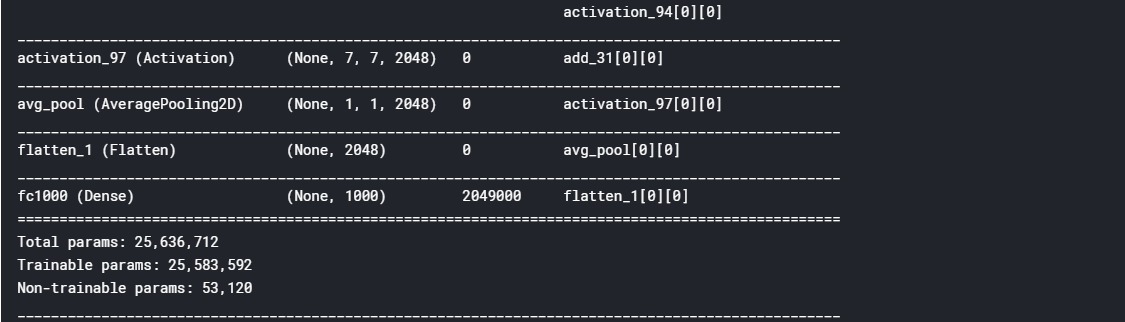




What this implies is that the model is capable of classifying **1000  image categories** and basis this classication on **2048  patterns** it detects in the images. The contribution of the each of the 2048 pattern is ditermined by the weight matrix of last FC layer. The weight matrix of last FC layer ditermines the contribution of each GAP layer node to an image category. This  weight  can be interpreted as the  average contribution of the pattern ( called the Activation Map). The activation map is however not of the same size as the original image, so bilinear upsampling needs to be applied for comparison

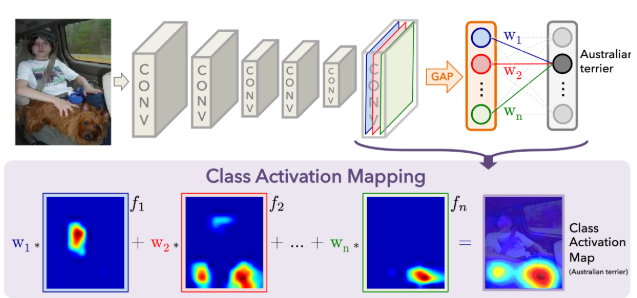

## 4. Implementation Details

1. Load pre-requisite packages  
2. Import pre-trained Resnet50 model  
3. Get the weights Wc of the last fully connected layer ( dim: 2048 x 1000 )
4. Create a new model from the original ResNet50 model that is same as ResetNet50 model but also outputs the Input to the GAP layer i.e. the output of the 4th last layer.
5.  Load the single image that needs to be predicted and the object  localized and set its size 224 x 224.
6.  Run predict() function for the loaded image. It shall returns the outputs of the last and fourth last layer of the model.
7. The Class Activation Map ( CAM ) is output the fourth last layer of dimension ( 1 x 7 x 7 x 2028 ) which is collapsed to 7 x 7 x 2048
8.  Zoom it to the size of original image  i.e. of dimmension 224 x 224 x2048
9.  Unroll each Activation Map to a 1-D vector such that we have 2048 1-D representation of Activation Maps  = ( dim: (224 *224) x 2048 ) )
10. Get weight of the predicted class  wc = Wc[ : , Pc ]  dim: (2048 x 1)
11. Get the Class Activation Map for the predicted image = Dot Product ( Activation Map , Wc ) dim: (224*224, )
12. Reshape to 224 x 224 image szie
12. Superipose the heat map of the CAM over Original image, each with with 0.5 transparancy 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.keras.models import Sequential, Model
#from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Dense
import scipy
import cv2     
import matplotlib.pyplot as plt
import ast

In [ ]:
def get_base_model():
    resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
    base_model = ResNet50( weights=resnet_weights_path)
    #print(base_model.summary())
    return base_model

In [ ]:
def get_new_model( base_model ):
    #get_weights returns a list where the 0th index are the weights and 1st index is the bias
    # we do not care for the bias henc ewe only get weights present at the 0th index
    weights_last_classification_layer = base_model.layers[-1].get_weights()[0] # dim: 2048 * 1000
   
    # create a new model with the output that we want. Since we want to get activation map of the  layer just before Global Average Pooling layer, we add its output as the output 
    #of our new model
    new_model = Model(inputs=base_model.input, 
        outputs=(base_model.layers[-4].output, base_model.layers[-1].output)) 
    
    return new_model, weights_last_classification_layer

In [ ]:
from keras.preprocessing import image   

# the image that is originally in 3D width*height* chanels. If we look at our model summary we see that the Input is required to be a 4D tensor
# Hence we converting our input image in 3D format ( width*height*channel) to 4D tensor and apply pre-processing that Resnet base model applied during training

def prepare_image_for_prediction( img_path):
    # loads the input image as PIL ( Python Image Libraray ) image
    img = image.load_img(img_path, target_size=(224, 224))
    # the below function returns a 3D numpy array (width * height *channel )
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    x = np.expand_dims(x, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(x)

In [ ]:
def ResNet_CAM(img_path, model, weights_last_classification_layer):
    # get filtered images from convolutional output + model prediction vector
    last_conv_output, pred_vec = model.predict(prepare_image_for_prediction(img_path))
    # Refer to the model summary. The output of the last convolution layer is 4D. Convert it to 3D 
    # change dimensions of last convolutional output to 7 x 7 x 2048. The squeeze function drops the dimensions with value 1 by default
    # We now get 2048 activation maps of size 7 X 7 
    last_conv_output = np.squeeze(last_conv_output) 
    
    # get model's prediction (number between 0 and 999, inclusive)
    pred_class = np.argmax(pred_vec)
    # bilinear upsampling to resize each filtered image to size of original image 
    # The original image is 224 X 244 in width and height. Activation maps are of size 7 X 7. Zoom factor = 224/7 = 32. The factor remains 1 for  the channel dimension
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # dim: 224 x 224 x 2048
    # get weights from the last classification layer for the class predicted for the input image
    predicted_class_weights = weights_last_classification_layer[:, pred_class] # dim: (2048,) 
    # get class activation map for object class that is predicted to be in the image
    final_output = np.dot(feature_activation_maps.reshape((224*224, 2048)), predicted_class_weights).reshape(224,224) # dim: 224 x 224
    # return class activation map
    return final_output, pred_class

In [ ]:
def plot_ResNet_CAM(orig_image_path,CAM,imagenet100_clsid_to_text_path,pred_class ):
  
    im = image.load_img(orig_image_path, target_size=(224, 224))
    # plot image
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 20)
    ax[0].imshow(im)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    ax[1].imshow(im, alpha=0.5)
    ax[1].imshow(CAM, cmap='jet', alpha=0.5)
    ax[1].axis('off')
   
    # get the category name
    with open(imagenet100_clsid_to_text_path) as imagenet_classes_file:
        imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())
    ax[1].set_title(imagenet_classes_dict[pred_class].split(',')[0])    
    plt.show()

## Let us attempt classification and object localization on some images:

In [ ]:
base_model = get_base_model()
new_model, weights_last_classification_layer = get_new_model(base_model)
imagenet100_clsid_to_text_path = '../input/imagenetcategorytext/imagenet1000_clsid_to_human.txt'


In [ ]:
img_path='../input/stl10/test_images/test_image_png_1024.png'
CAM, pred_class = ResNet_CAM(img_path, new_model, weights_last_classification_layer )
plot_ResNet_CAM(img_path, CAM, imagenet100_clsid_to_text_path, pred_class )

In [ ]:
img_path='../input/stl10/test_images/test_image_png_1026.png'
CAM, pred_class = ResNet_CAM(img_path, new_model, weights_last_classification_layer )
plot_ResNet_CAM(img_path, CAM, imagenet100_clsid_to_text_path, pred_class )

In [ ]:
img_path='../input/stl10/test_images/test_image_png_1030.png'
CAM, pred_class = ResNet_CAM(img_path, new_model, weights_last_classification_layer )
plot_ResNet_CAM(img_path, CAM, imagenet100_clsid_to_text_path, pred_class )

## References

[1] https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/  
[2] http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf  